In [ ]:
#meta 1/11/2021 Cassava. TPU Intro
#https://www.kaggle.com/jessemostipak/getting-started-tpus-cassava-leaf-disease

# Introduction



**TPUs with TensorFlow**  
We'll be using TensorFlow and Keras to build our computer vision model, and using TPUs to both train our model and make predictions. If you'd like to learn about more about TPUs be sure to check out our **[Learn With Me: Getting Started with Tensor Processing Units (TPUs)](https://youtu.be/1pdwRQ1DQfY)** video.  

**References**  
This notebook was built using the following amazing resources created by Kagglers:
- **Martin Gorner:** [Getting Started With 100 Flowers on TPU](https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu)
- **Amy Jang:** [TensorFlow + Transfer Learning: Melanoma](https://www.kaggle.com/amyjang/tensorflow-transfer-learning-melanoma)
- **Phil Culliton:** [A Simple TF 2.1 Notebook](https://www.kaggle.com/philculliton/a-simple-tf-2-1-notebook)

# Tensor Processing Units (TPUs)

Tensor Processing Units (TPUs) are hardware accelerators that are specialized for deep learning tasks. All Kagglers have 30 hours of free TPU time each week, and can use up to 3 hours in a single session (although if you'd like to increase your TPU quota consider submitting an exemplary TPU notebook to our **[TPU Star program](https://www.kaggle.com/tpu-prize)**!)   

You can read through the Kaggle documentation on TPUs **[here](https://www.kaggle.com/docs/tpu)**, and check out the TPU Star notebooks **[here](https://www.kaggle.com/tpu-stars)**.

# Set up environment

In [1]:
import math, re, os, warnings, random
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
from tensorflow import keras
from functools import partial
from sklearn.model_selection import train_test_split


from sklearn.utils import class_weight
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, applications, Sequential, losses, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.2.0


# Detect TPU
What we're doing with our code here is making sure that we'll be sending our data across a TPU. What you're looking for is a printout of `Number of replicas: 8`, corresponding to the 8 cores of a TPU. If your printout instead says `Number of replicas: 1` you likely do not have TPUs enabled in your notebook.   

To enable TPUs navigate to the panel on the right and click on `Accelerator`. Choose TPU from the dropdown.  

If you'd like more TPU troubleshooting and optimization guidelines check out our **[Learn With Me: Troubleshooting and Optimizing TPUs video](https://youtu.be/BSeWHzjMHMU)**.  

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.0.0.2:8470
Number of replicas: 8


# Set up variables
We'll set up some of our variables for our notebook here. 

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [512, 512]
CLASSES = ['0', '1', '2', '3', '4']
EPOCHS = 25
HEIGHT = 512
WIDTH = 512
CHANNELS = 3


## Decode the data
In the code chunk below we'll set up a series of functions that allow us to convert our images into tensors so that we can utilize them in our model. We'll also normalize our data. Our images are using a "Red, Blue, Green (RBG)" scale that has a range of [0, 255], and by normalizing it we'll set each pixel's value to a number in the range of [0, 1]. 

In [4]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

You might notice that this function accounts for unlabeled images. This is because our test image doesn't have any labels.  

In [5]:
def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

We'll use the following function to load our dataset. One of the advantages of a TPU is that we can run multiple files across the TPU at once, and this accounts for the speed advantages of using a TPU. To capitalize on that, we want to make sure that we're using data as soon as it streams in, rather than creating a data streaming bottleneck.

In [6]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

In [7]:
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/ld_train*.tfrec'),
    test_size=0.35, random_state=5
)

TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test_tfrecords/ld_test*.tfrec')

## Adding in augmentations 


In [8]:
def data_augment(image, label):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Shear
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, HEIGHT, shear=20.)
        else:
            image = transform_shear(image, HEIGHT, shear=-20.)
            
    # Rotation
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, HEIGHT, rotation=45.)
        else:
            image = transform_rotation(image, HEIGHT, rotation=-45.)
            
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
    # Crops
    if p_crop > .7:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    elif p_crop > .4:
        crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])

    return image, label

In [9]:
# data augmentation @cdeotte kernel: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.uniform([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.uniform([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

## Define data loading methods
The following functions will be used to load our `training`, `validation`, and `test` datasets, as well as print out the number of images in each dataset.

In [10]:
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)  
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)  
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [11]:
def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALID_FILENAMES, labeled=True, ordered=ordered) 
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [12]:
def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [13]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [14]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

print('Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 13380 training images, 8017 validation images, 1 (unlabeled) test images


# Brief exploratory data analysis (EDA)
First we'll print out the shapes and labels for a sample of each of our three datasets:

In [15]:
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Training data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Training data label examples: [3 3 3 2 2 3 2 3 3 3 3 3 3 3 3 3 3 3 3 2 0 4 2 3 4 3 2 4 2 3 3 3 1 3 3 3 0
 3 3 3 3 3 3 2 2 2 4 4 4 4 3 3 0 3 3 1 3 3 0 3 3 4 3 3 3 1 3 0 3 2 3 0 3 3
 3 3 3 3 3 2 2 3 3 2 4 3 3 2 3 3 3 3 3 1 3 2 4 1 3 1 0 3 1 3 3 3 3 3 3 1 3
 0 4 3 2 3 1 4 3 3 3 3 3 3 3 2 3 3]
Validation data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Validation data label examples: [3 3 3 3 3 2 1 3 3 4 3 3 3 3 0 3 1 3 2 3 1 1 3 1 3 3 3 4 3 1 3 1 3 3 3 3 3
 3 3 3 1 3 3 3 3 0 3 3 3 3 4 3 2 3 3 3 3 2 2 3 2 3 1 2 3 2 4 3 4 3 4 3 3 3
 4 3 3 4 3 3 4 3 3 4 0 4 2 3 4 3 3 1 3 2 3 3 2 3 3 3 3 3 3 3 1 2 3 3 4 3 1
 3 0 2 4 0 3 3 3 3 4 4 2 4 3 3 3 3]
Test data shapes:
(1, 512, 512, 3) (1,)
Test data IDs: ['2216849948.jpg']


The following code chunk sets up a series of functions that will print out a grid of images. The grid of images will contain images and their corresponding labels.

In [16]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_plant(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_plant(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [17]:
# load our training dataset for EDA
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

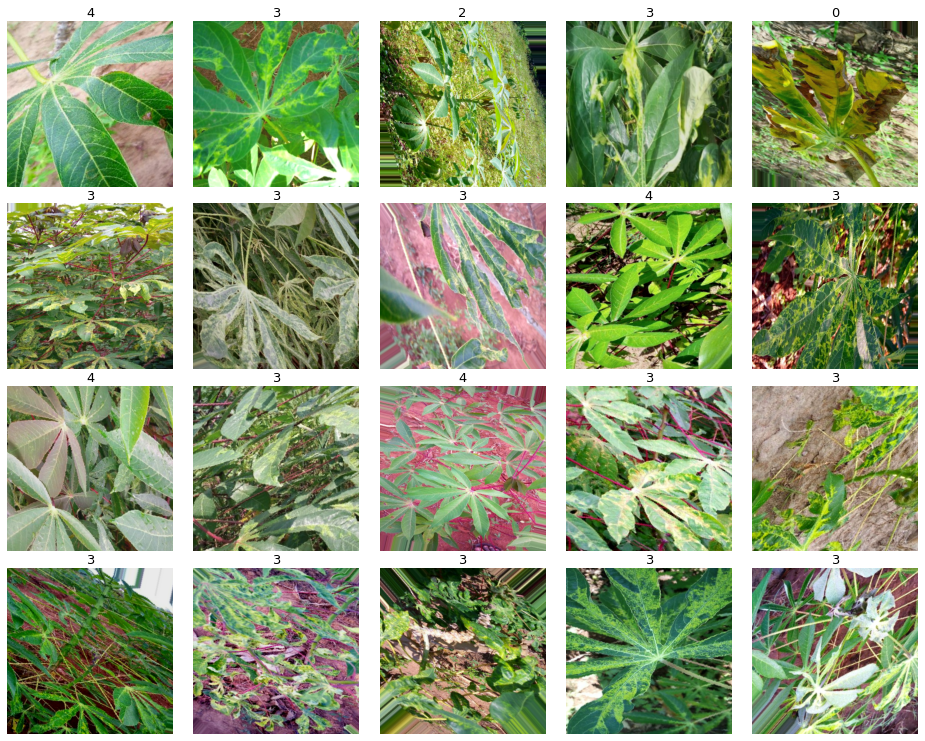

In [18]:
# run this cell again for another randomized set of training images
display_batch_of_images(next(train_batch))

You can also modify the above code to look at your `validation` and `test` data, like this:

In [19]:
# load our validation dataset for EDA
validation_dataset = get_validation_dataset()
validation_dataset = validation_dataset.unbatch().batch(20)
valid_batch = iter(validation_dataset)

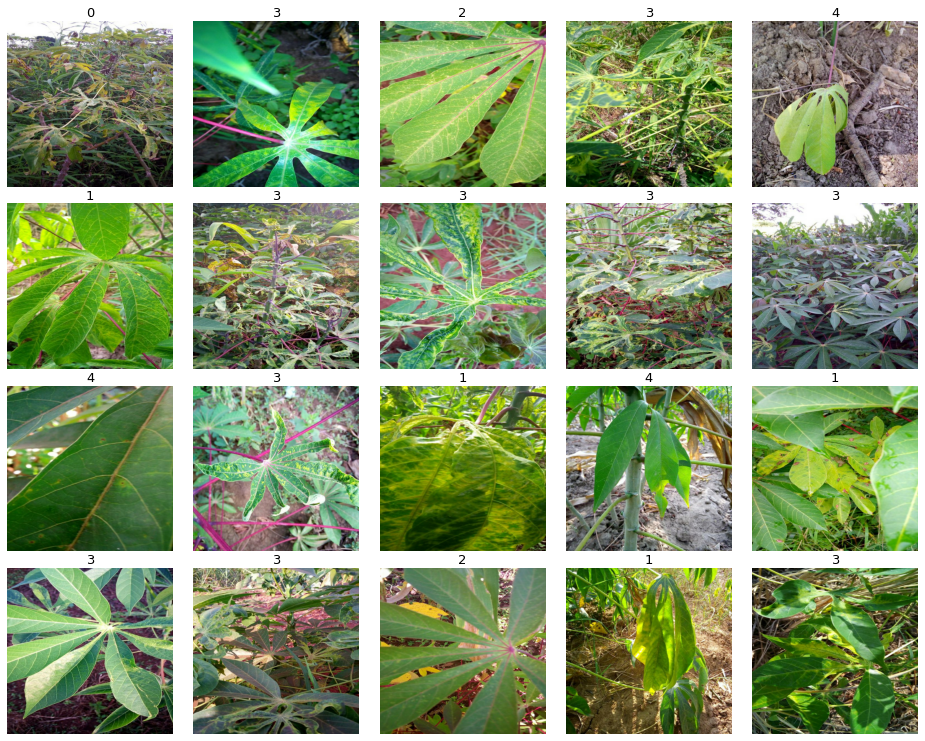

In [20]:
# run this cell again for another randomized set of training images
display_batch_of_images(next(valid_batch))

In [21]:
# load our test dataset for EDA
testing_dataset = get_test_dataset()
testing_dataset = testing_dataset.unbatch().batch(20)
test_batch = iter(testing_dataset)

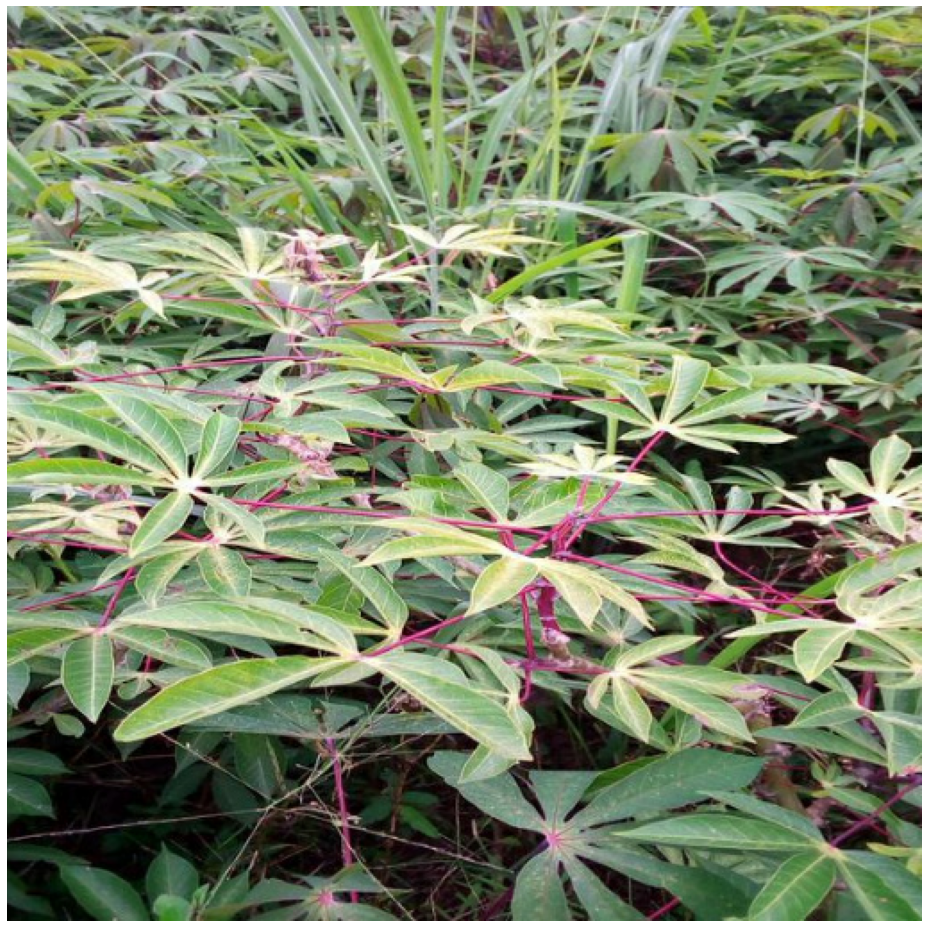

In [22]:
# we only have one test image
display_batch_of_images(next(test_batch))

# Building the model
## Learning rate schedule


In [23]:
lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5, 
    decay_steps=10000, 
    decay_rate=0.9)

## Building our model
In order to ensure that our model is trained on the TPU, we build it using `with strategy.scope()`.    

We will use _pre-trained model_ (ResNet50) as our base model 

Note that we're using `sparse_categorical_crossentropy` as our loss function, because we did _not_ one-hot encode our labels.

In [24]:
with strategy.scope():       
    img_adjust_layer = tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input, input_shape=[*IMAGE_SIZE, 3])
    
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(renorm=True),
        img_adjust_layer,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation='relu'),
        #tf.keras.layers.BatchNormalization(renorm=True),
        #tf.keras.layers.Dropout(0.5)(x)
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')  
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler, epsilon=0.001),
        loss='sparse_categorical_crossentropy',  
        metrics=['sparse_categorical_accuracy'])

94773248/94765736 [==============================] - 1s 0us/step


In [25]:
'''STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

history = model.fit(training_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=VALID_STEPS)
'''

'STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE\nVALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE\n\nhistory = model.fit(training_dataset, \n                    steps_per_epoch=STEPS_PER_EPOCH, \n                    epochs=EPOCHS,\n                    validation_data=validation_dataset,\n                    validation_steps=VALID_STEPS)\n'

# Train the model
As our model is training you'll see a printout for each epoch, and can also monitor TPU usage by clicking on the TPU metrics in the toolbar at the top right of your notebook.

In [26]:
# load data
train_dataset = get_training_dataset()
valid_dataset = get_validation_dataset()

In [27]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS)

Epoch 1/25
104/104 [==============================] - 69s 659ms/step - sparse_categorical_accuracy: 0.5611 - loss: 1.2477 - val_sparse_categorical_accuracy: 0.6085 - val_loss: 1.1811
Epoch 2/25
104/104 [==============================] - 51s 493ms/step - sparse_categorical_accuracy: 0.6160 - loss: 1.1505 - val_sparse_categorical_accuracy: 0.6100 - val_loss: 1.1488
Epoch 3/25
104/104 [==============================] - 53s 508ms/step - sparse_categorical_accuracy: 0.6233 - loss: 1.1011 - val_sparse_categorical_accuracy: 0.6150 - val_loss: 1.0948
Epoch 4/25
104/104 [==============================] - 49s 470ms/step - sparse_categorical_accuracy: 0.6257 - loss: 1.0739 - val_sparse_categorical_accuracy: 0.6184 - val_loss: 1.0639
Epoch 5/25
104/104 [==============================] - 48s 466ms/step - sparse_categorical_accuracy: 0.6325 - loss: 1.0483 - val_sparse_categorical_accuracy: 0.6235 - val_loss: 1.0438
Epoch 6/25
104/104 [==============================] - 50s 480ms/step - sparse_categor

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo multiple                  21        
_________________________________________________________________
lambda (Lambda)              multiple                  0         
_________________________________________________________________
resnet50 (Model)             (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2098176   
_________________________________________________________________
dense_1 (Dense)              multiple                  5125      
Total params: 25,691,034
Trainable params: 2,103,307
Non-trainable params: 23,587,727
____________________________________

In [29]:
# print out variables available to us
print(history.history.keys())

dict_keys(['sparse_categorical_accuracy', 'loss', 'val_sparse_categorical_accuracy', 'val_loss'])


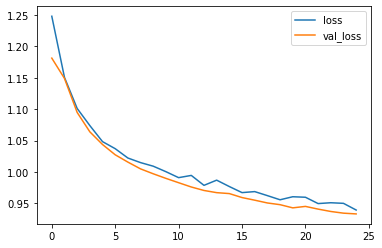

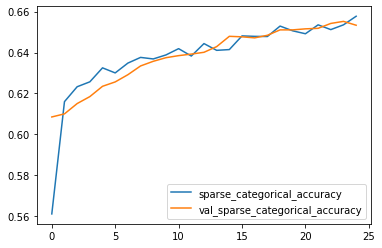

In [30]:
# create learning curves to evaluate model performance
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();

In [31]:
# Model Save
model.save('model_cassava.h5')

# Making predictions
Now that we've trained our model we can use it to make predictions! 

In [32]:
# this code will convert our test image data to a float32 
def to_float32(image, label):
    return tf.cast(image, tf.float32), label

In [33]:
test_ds = get_test_dataset(ordered=True) 
test_ds = test_ds.map(to_float32)

print('Computing predictions...')
test_images_ds = testing_dataset
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

Computing predictions...
[3]


# Creating a submission file


In [34]:
print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
!head submission.csv

Generating submission.csv file...
id,label
2216849948.jpg,3


Be aware that because this is a code competition with a hidden test set, internet and TPUs cannot be enabled on your submission notebook. Therefore TPUs will only be available for training models. For a walk-through on how to train on TPUs and run inference/submit on GPUs, see our [TPU Docs](https://www.kaggle.com/docs/tpu#tpu6).